<a href="https://colab.research.google.com/github/clerfayt28/Pitonchik/blob/main/%D0%9B%D0%B0%D0%B1%D0%B03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.animation import FuncAnimation
from functools import partial
from IPython.display import HTML, display

In [13]:
N = 51                            # Размер сетки
N_eq = (N - 2) * (N - 1)          # Кол-во уравнений
L = 1                             # Длина стержня
t_all = 600                       # Время расчета
lmbda = 55                        # Коэф-т теплопроводности
C_p = 490                         # Коэф-т теплоемкости
rho = 7850                        # Плотность
x = np.linspace(0, L, N)
t = np.linspace(0, t_all, N)
dx = x[1] - x[0]
dt = t[1] - t[0]
# Коэффициенты уравнений
a = lmbda / dx
b = rho * C_p * dx / dt
c = -2 * a - b

# Инициализация матрицы коэффициентов и вектора известных

In [14]:
M = np.zeros((N_eq, N_eq))
K = np.zeros((N_eq))

# Начальные и граничные условия

In [15]:
T = np.zeros((N, N))
# Для 1 и 3 варианта
T[:, -1] = -100 * t * dx / lmbda      # x = L (T(N, k) = T(N - 1, k) -f(t) * dx / lmbda)
# T[:, -1] = 323                      # x = L
T[:, 0] = 273                         # x = 0
T[0, :] = 273 + 50 * x / L            # t = 0

# Заполнение матрицы коэффициентов и вектора известных

In [16]:
# Матрица коэффициентов
for i in range(M.shape[1]):
    # Заполнение главной диагонали для T(i, k)
    M[i, i] = c
    if not (i + 1) % (N - 2): # Для 1 и 3 варианта
        # T(N, k) = T(N - 1, k) -f(t) * dx / lmbda
        M[i, i] += a
    if i < M.shape[1] - 1:
        if (i + 1) % (N - 2):
            # Заполнение диагонали для T(i - 1, k)
            M[i + 1, i] = a
            # Заполнение диагонали для T(i + 1, k)
            M[i, i + 1] = a
    if i < M.shape[1] - N + 2:
        # Заполнение диагонали для T(i, k - 1)
        M[i  + N - 2, i] = b

count = 0

# Матрица известных
for i in range(N - 1):
    for j in range(N - 2):
        if not i:
            # Заполнение известных при T(i, 0)
            K[count] += -T[i, j + 1] * b
        if not j:
            # Заполнение известных при T(0, k)
            K[count] += -T[i + 1, j] * a
        elif j == N - 3:
            # Заполнение известных при T(L, k)
            K[count] += -T[i + 1, j + 2] * a
        count += 1

# Расчет результирующего поля температур

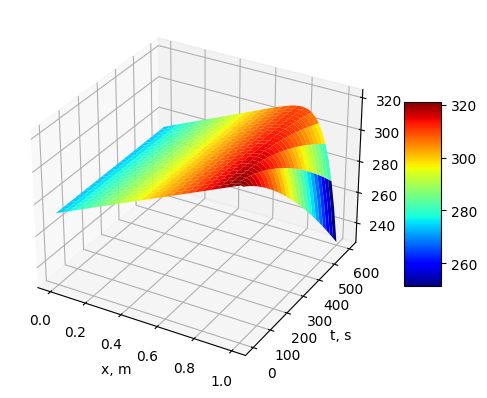

In [17]:
# Решение СЛАУ
T_result = np.linalg.solve(M, K)

# Компоновка поля температур
T[1:, 1:-1] = T_result.reshape(N-1, -1)
# T(N, k) = T(N - 1, k) -f(t) * dx / lmbda
T[1:, -1] += + T[1:, -2] # Для 1 и 3 варианта

# Визуализация поля температур

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
xx, tt = np.meshgrid(x, t)
surf = ax.plot_surface(xx, tt, T, cmap=cm.jet)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x, m')
plt.ylabel('t, s')
plt.show()

# Анимация поля температур


In [18]:
fig, ax = plt.subplots()
line1, = ax.plot([], [])
plt.xlabel('x, m')
plt.ylabel('T, K')

def init():
    ax.set_xlim(0, L)
    ax.set_ylim(T.min() - T.mean() * 0.1, T.max() + T.mean() * 0.1)
    return line1,

def update(frame, ln, x, y):
    y = T[frame]
    ln.set_data(x, y)
    ax.set_title(f't = {t[frame]}')
    return ln,

ani = FuncAnimation(
    fig, partial(update, ln=line1, x=x, y=T[0]),
    frames=np.arange(N),
    init_func=init, blit=True)

display(HTML(ani.to_jshtml()))
plt.close(fig)